In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the combined parquet data

file_path = '/Users/maushariff/Downloads/Local_Disk_E/Byrav/Internet2_Data/Atla/combined_internet_traffic_data.parquet'
df = pd.read_parquet(file_path)


In [3]:
# Check the column names in the DataFrame
print(df.columns)


Index(['export_sysid', 't_first', 't_last', 'proto', 'src4_addr', 'dst4_addr',
       'src_port', 'dst_port', 'src_tos', 'dst_tos', 'in_packets',
       'input_snmp', 'output_snmp', 'src_as', 'dst_as', 'src_mask', 'dst_mask',
       'ip4_next_hop', 'ip4_router', 'src6_addr', 'dst6_addr', 'ip6_next_hop'],
      dtype='object')


In [4]:
# Convert 't_last' to datetime and set it as the index
df['t_last'] = pd.to_datetime(df['t_last'])  # Convert to datetime
df.set_index('t_last', inplace=True)  # Set 't_last' as the index

# Resample to hourly traffic volume
hourly_data = df['in_packets'].resample('H').sum().reset_index()

# Rename columns for Prophet compatibility (ds for date, y for values)
hourly_data.columns = ['ds', 'y']

# Check the first few rows to confirm
print(hourly_data.head())


/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_59010/4161484110.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df['in_packets'].resample('H').sum().reset_index()


                   ds          y
0 2021-10-07 23:00:00     390000
1 2021-10-08 00:00:00  585470000
2 2021-10-08 01:00:00  559475000
3 2021-10-08 02:00:00  547740000
4 2021-10-08 03:00:00  613875000


In [5]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_data[['y']])

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (how many previous hours to use to predict the next hour)
sequence_length = 24  # Using 24 previous hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training samples: {X_train.shape}, Testing samples: {X_test.shape}')


Training samples: (596, 24, 1), Testing samples: (149, 24, 1)


In [35]:
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Define the model
model = Sequential()

# First layer - GRU with return_sequences=True to stack with LSTM
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.25))  # Dropout layer to prevent overfitting

# Second layer - LSTM
model.add(LSTM(256))
model.add(Dropout(0.2))  # Another dropout layer

# Dense layers
model.add(Dense(64, activation='relu'))  # Dense layer with ReLU activation
model.add(Dense(1))  # Output layer with a single output (for regression)

# Compile the model
# model.compile(optimizer='adam', loss='mse')
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])

checkpoint = ModelCheckpoint("weights.best.keras", monitor='val_mse', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=8,  verbose=0, callbacks=callbacks_list, validation_data=(X_val, y_val))


# Make predictions
predictions = model.predict(X_test)

# Inverse transform if necessary
# predictions_rescaled = scaler.inverse_transform(predictions)

# Evaluate the model (optional)
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Data: {mse}")



Epoch 1: val_mse improved from inf to 0.04374, saving model to weights.best.keras

Epoch 2: val_mse improved from 0.04374 to 0.03587, saving model to weights.best.keras

Epoch 3: val_mse did not improve from 0.03587

Epoch 4: val_mse did not improve from 0.03587

Epoch 5: val_mse did not improve from 0.03587

Epoch 6: val_mse did not improve from 0.03587

Epoch 7: val_mse improved from 0.03587 to 0.03228, saving model to weights.best.keras

Epoch 8: val_mse improved from 0.03228 to 0.03179, saving model to weights.best.keras

Epoch 9: val_mse did not improve from 0.03179

Epoch 10: val_mse did not improve from 0.03179

Epoch 11: val_mse did not improve from 0.03179

Epoch 12: val_mse improved from 0.03179 to 0.03013, saving model to weights.best.keras

Epoch 13: val_mse improved from 0.03013 to 0.02595, saving model to weights.best.keras

Epoch 14: val_mse improved from 0.02595 to 0.02282, saving model to weights.best.keras

Epoch 15: val_mse improved from 0.02282 to 0.02176, saving m

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Inverse scale to get original values
predicted_train_rescaled = scaler.inverse_transform(predicted_train)
predicted_test_rescaled = scaler.inverse_transform(predicted_test)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE and RMSE
train_mae = mean_absolute_error(y_train_rescaled, predicted_train_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, predicted_test_rescaled)
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, predicted_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_test_rescaled))

print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}')
print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train MAE: 56377816.0, Train RMSE: 72857045.43552586
Test MAE: 173630119.51677853, Test RMSE: 208193531.42224452


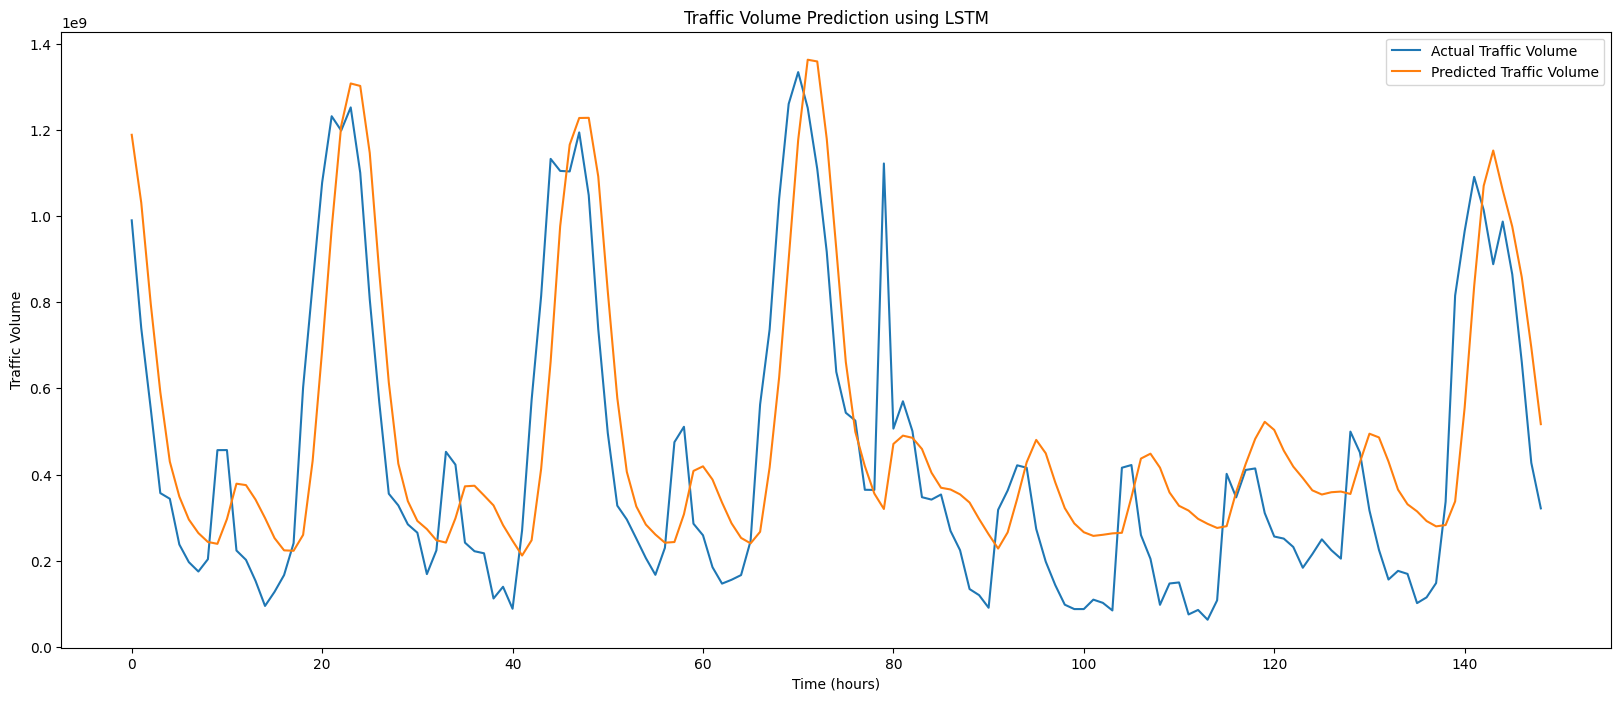

In [37]:
import matplotlib.pyplot as plt

# Plot the predictions vs actual values
plt.figure(figsize=(20, 8))

plt.plot(y_test_rescaled, label='Actual Traffic Volume')
plt.plot(predicted_test_rescaled, label='Predicted Traffic Volume')
plt.title('Traffic Volume Prediction using LSTM')
plt.xlabel('Time (hours)')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mse', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=200, batch_size=100, verbose=0, callbacks=callbacks_list, validation_split=0.1)